# 数据处理

## 数据准备

In [14]:
from src.data.get_data_list import get_data_list

dataset_path = "dataset"  
#将数据集转化为标准形式 
get_data_list(dataset_path)

converting voc color png to gray png ...
converting done.
generating voc train list success.
generating voc val list success.
converting sbd annotations to png ...
converting done
generating voc train aug list success.


In [15]:
 #TODO 合并
from src.data.build_seg_data import build_data ##TODO 改名

# VOC数据集的根目录
data_root = "" #TODO  为什么目录有问题

# 分割数据标注文件的位置
data_lst = 'dataset/vocaug_train_lst.txt' 

# 存放生成MindRecord数据的路径
dst_path = 'dataset/mindname.mindrecord' #*
# print(os.path.join(data_root, "wee.jpg"))
# mindrecord超参数
num_shards = 1

# 是否打乱 
shuffle = True

build_data(data_root, data_lst, dst_path, num_shards, shuffle)

number of samples: 10582


RuntimeError: Unexpected error. Invalid file, mindrecord files already exist. Please check file path: d:\IT\code\FCN\dataset\mindname.mindrecord.
If you do not want to keep the files, set the 'overwrite' parameter to True and try again.
Line of code : 116
File         : D:\jenkins\agent-working-dir\workspace\Compile_CPU_Windows_PY39\mindspore\mindspore\ccsrc\minddata\mindrecord\io\shard_writer.cc


## 数据加载

In [ ]:
from src.data import dataset as data_generator
#创建数据集的参数
image_mean = [103.53, 116.28, 123.675]
image_std = [57.375, 57.120, 58.395]

data_file = "dataset/mindname.mindrecord"
#  = "dataset/VOCdevkit/VOC2012"
num_classes = 21 
train_batch_size = 2
crop_size = 512

min_scale = 0.5
max_scale = 2.0

ignore_label = 255
rank = None
group_size = None

# 构建数据集 
dataset = data_generator.SegDataset(image_mean=image_mean,
                                        image_std=image_std,
                                        data_file=data_file,
                                        batch_size=train_batch_size,
                                        crop_size=crop_size,
                                        max_scale=max_scale,
                                        min_scale=min_scale,
                                        ignore_label=ignore_label,
                                        num_classes=num_classes,
                                        num_readers=2,
                                        num_parallel_calls=4,
                                        shard_id=rank,
                                        shard_num=group_size)

dataset = dataset.get_dataset(repeat=1)


## 训练集可视化

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


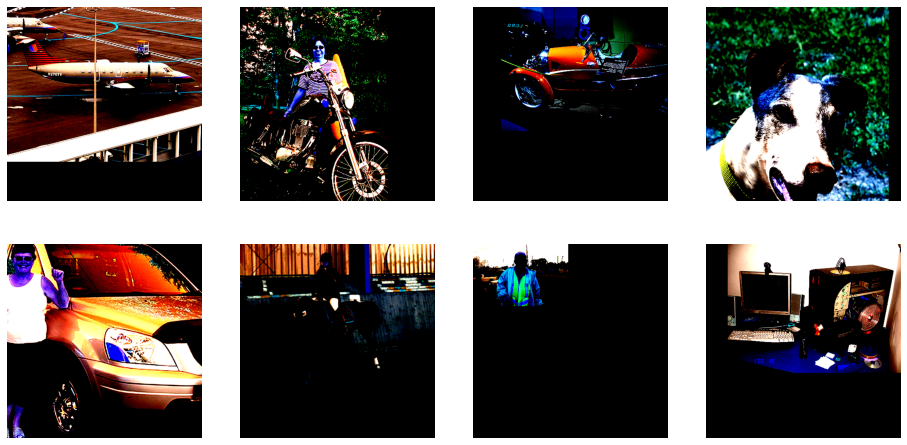

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

# 展示图片供参考
for i in range(1, 9):
    plt.subplot(2, 4, i)
    show_data = next(dataset.create_dict_iterator())

    show_images = show_data["data"].asnumpy()
    # print(f'Image shape: {show_images.shape}')
    
    # 将图片转换HWC格式后显示
    plt.imshow(show_images[0].transpose(1,2,0))
    plt.axis("off")
    # plt.subplots_adjust(wspace=0.05, hspace=0)

## 模型构建

In [ ]:
import mindspore as ms
import mindspore.nn as nn
from mindspore.ops import operations as P
ms.set_seed(23)

# VGG Cell
class conv(nn.Cell):
    # 输入维度, 输出维度, 卷积层数
    def __init__(self, in_ch, out_ch, num):
        super(conv, self).__init__()
        conv_list = [nn.SequentialCell(nn.Conv2d(out_ch, out_ch, 3, weight_init='xavier_uniform'), nn.BatchNorm2d(out_ch), nn.ReLU()) for i in range(num - 1)]
        self.conv = nn.SequentialCell([nn.Conv2d(in_ch, out_ch, 3, weight_init='xavier_uniform'),
                                             nn.BatchNorm2d(out_ch), nn.ReLU()] + conv_list)
##TODO Test
    def construct(self, x):
        x = self.conv(x)
        return x

class FCN8s(nn.Cell):
    def __init__(self, n_class):
        super().__init__()
        self.n_class = n_class
        # VGG BackBone
        self.conv1 = conv(3, 64, 2)
        # [N,3,224,224]->[N,64,224,224]
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # [N,64,224,224]->[N,64,112,112]

        self.conv2 = conv(64, 128, 2)
        # [N,64,112,112]->[N,128,112,112]
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # [N,128,112,112]->[N,128,56,56]


        self.conv3 = conv(128, 256, 3)
        # [N,128,56,56]->[N,256,56,56]
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # [N,256,56,56]->[N,256,28,28]

        self.conv4 = conv(256, 512, 3)
        # [N,256,28,28]->[N,512,28,28]
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        # [N,512,28,28]->[N,512,14,14]

        self.conv5 = conv(512, 512, 3)
        # 维数不变
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        # [N,512,14,14]->[N,512,7,7]
        #TODO 前面part替换为VGG
        
        self.conv6 = nn.SequentialCell(
            nn.Conv2d(in_channels=512, out_channels=4096,
                      kernel_size=7, weight_init='xavier_uniform'), #TODO 用属性替换xavier
            nn.BatchNorm2d(4096),
            nn.ReLU(),
        )
        self.conv7 = nn.SequentialCell(
            nn.Conv2d(in_channels=4096, out_channels=4096,
                      kernel_size=1, weight_init='xavier_uniform'),
            nn.BatchNorm2d(4096),
            nn.ReLU(),
        )
        self.score_fr = nn.Conv2d(in_channels=4096, out_channels=self.n_class,
                                   kernel_size=1, weight_init='xavier_uniform')
        
        self.upscore2 = nn.Conv2dTranspose(in_channels=self.n_class, out_channels=self.n_class,
                                           kernel_size=4, stride=2, weight_init='xavier_uniform')
        self.score_pool4 = nn.Conv2d(in_channels=512, out_channels=self.n_class,
                                     kernel_size=1, weight_init='xavier_uniform')
        self.upscore_pool4 = nn.Conv2dTranspose(in_channels=self.n_class, out_channels=self.n_class,
                                                kernel_size=4, stride=2, weight_init='xavier_uniform')
        self.score_pool3 = nn.Conv2d(in_channels=256, out_channels=self.n_class,
                                     kernel_size=1, weight_init='xavier_uniform')
        self.upscore8 = nn.Conv2dTranspose(in_channels=self.n_class, out_channels=self.n_class,
                                           kernel_size=16, stride=8, weight_init='xavier_uniform')
        self.shape = P.Shape()
        self.cast = P.Cast()
        self.add1 = P.Add()
        self.add2 = P.Add()

    # 前向过程
    def construct(self, x):
        x1 = self.conv1(x)
        p1 = self.pool1(x1)
        x2 = self.conv2(p1)
        p2 = self.pool2(x2)
        x3 = self.conv3(p2)
        p3 = self.pool3(x3)
        x4 = self.conv4(p3)
        p4 = self.pool4(x4)
        x5 = self.conv5(p4)
        p5 = self.pool5(x5)

        x6 = self.conv6(p5)
        x7 = self.conv7(x6)

        sf = self.score_fr(x7)
        u2 = self.upscore2(sf)

        s4 = self.score_pool4(p4)
        f4 = self.add1(s4, u2)
        u4 = self.upscore_pool4(f4)

        s3 = self.score_pool3(p3)
        f3 = self.add2(s3, u4)
        out = self.upscore8(f3)

        return out
##TODO 梳理 

In [ ]:
net = FCN8s(n_class=21)

In [ ]:
from mindspore.common.initializer import One, Normal

t = ms.Tensor(shape=(16, 3, 224, 224), dtype=ms.float32, init=Normal())
result = net(t)